In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In the cell below I'm just calling the folder in which I have installed BOSS library. The variable "nb_path" should be a path to one of your folders.

In [ ]:
#!pip3 install --target=$nb_path aalto-boss
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import boss

In [ ]:
# Loading of the libraries I might want to use during this project.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

import xgboost as xgb

# BOSS
from boss.bo.bo_main import BOMain
from boss.pp.pp_main import PPMain

# Functions used in this notebook

def make_histograms(data1,data2):
    """
    This function plots histograms of two dataset.
      Data1 - is the bigger dataset (eg. DF_full)
      Data2 - is the smaller dataset (eg. DF_small, DF_5k ect...)
    """
    import matplotlib.pyplot as plt
    f, ax = plt.subplots(3,3,figsize=[15,12])
    for i,c in enumerate(data1.columns):
        y, x, _ = ax[i//3][i%3].hist(data1[c],bins=100,color='k')
        _ = ax[i//3][i%3].hist(data2[c],bins=100,color='r')
        ax[i//3][i%3].set_title(c)
        ax[i//3][i%3].set_yscale('log')
        medianfull = np.median(data1[c])
        medianredc = np.median(data2[c])

        meanfull = np.mean(data1[c])
        meanredc = np.mean(data2[c])

        ax[i//3][i%3].vlines(medianfull,y.max(),y.max()*10,color='c')
        ax[i//3][i%3].vlines(medianredc,y.max(),y.max()*10,color='m')
        ax[i//3][i%3].text(medianfull,y.max()*10,' MedianF',ha='left',color='c') # "F" means full
        ax[i//3][i%3].text(medianredc,y.max()*10,'MedianR ',ha='right',color='m') # "R" means reduced

        ax[i//3][i%3].vlines(meanfull,y.max()*20,y.max()*50,color='g')
        ax[i//3][i%3].vlines(meanredc,y.max()*20,y.max()*50,color='b')
        ax[i//3][i%3].text(meanfull,y.max()*50,' MeanF',ha='left',color='g')
        ax[i//3][i%3].text(meanredc,y.max()*50,'MeanR ',ha='right',color='b')

# Loading full dataframe from google drive
columns = ['T_e','T_bb','tau_T','E','Mu','I','U']
DF_full = pd.read_csv('/content/drive/MyDrive/Turku/MLMScourse/data_AMP_PCS.csv', names=columns )

# Smaller sets
DF_5k = DF_full.sample(5000)
DF_10k = DF_full.sample(10000)
DF_15k = DF_full.sample(15000)
DF_30k = DF_full.sample(30000)
DF_60k = DF_full.sample(50000)
DF_75k = DF_full.sample(75000)
DF_100k = DF_full.sample(100000)

In [ ]:
def get_folds(DF,n_fold=2):
    """
    This function splits dataset into train, test and validation AND makes different folds.
    Parameters:
      DF - dataframe which should be splitted.
      n_folds - number of folds (default = 2), intiger.
    Return:
      Train_x, Test_x, Val_x - list of folds for features in training/test/validation sets
      Train_y, Test_y, Val_y - list of folds for labels in training/test/validation sets
    """

    # Number of folds. Means that the whole dataset is divided into n_fold parts of equal sizes.
    DF.reset_index(drop=True,inplace=True)
    X = DF.drop(['I','U'],axis=1)
    Y = DF['I']

    # Create the KFold object.
    k_fold = KFold(n_splits=n_fold, shuffle=True,random_state=0)

    # Train and test indices for each fold:
    train_test_idx_in_folds = {k: (train, test) for k, (train, test) in enumerate(k_fold.split(DF))}

    # Choose indices of train and test sets from fold 0:
    fold = 0

    Train_x,Train_y =[],[]
    Test_x,Test_y = [],[]
    Val_x,Val_y = [],[]

    for i in range(n_fold):
        train_idx = train_test_idx_in_folds[i][0]
        test_idx = train_test_idx_in_folds[i][1]

        # I would like to have validation set. In this approach I'll naively split test set in two.
        # We could implement different way to split but I don't think that this is needed at this point.
        L = len(test_idx)//2

        # Pick input data for train and test sets (i.e., cleaned XRD intensities):
        Train_x.append(X.loc[train_idx])
        Test_x.append(X.loc[test_idx[:L]])
        Val_x.append(X.loc[test_idx[L:]])

        # Pick output data for train and test sets (i.e., sample dimensionalities):
        Train_y.append(Y.loc[train_idx])
        Test_y.append(Y.loc[test_idx[:L]])
        Val_y.append(Y.loc[test_idx[L:]])

    return(Train_x,Test_x,Val_x,Train_y,Test_y,Val_y)


def PredPlot_folds(model,Tr_x,Tr_y,Te_x,Te_y,Validate=False,Validation_set=None,Verbose=False):
    """
    With this function I can iterate through the folds and execute fitting on each.
    Parameters:
      model - XGBRegression model
      Tr_x,Tr_Y,Te_x,Te_y - training and test data
      Validate - boolean value. If true model will be validated.
      Validation_set - data for validation (tuple of data)
      Verbose - set True to print out additional information
    """

    Y_pred = []
    for i in range(len(Tr_x)):
        if Validate==False:
            model.fit(Tr_x[i],Tr_y[i],verbose=Verbose)
        else:
            model.fit(Tr_x[i],Tr_y[i],verbose=Verbose,eval_set=Validation_set)
        pred = model.predict(Te_x[i])
        print('Fold',i,'MAE:',mean_absolute_error(Te_y[i],pred))
        Y_pred.append(pred)


    Scores_all = []
    f, ax = plt.subplots(1,5,figsize=[20,5])
    for i in range(5):
        ax[i].scatter(Te_y[i],Y_pred[i],s=5,c='k')
        maxmax = int(max(max(Te_y[i]),max(Y_pred[i])))
        R2 = round(r2_score(Te_y[i],Y_pred[i]),4)
        MAE = round(mean_absolute_error(Te_y[i],Y_pred[i]),4)
        ax[i].plot([i for i in range(maxmax)],[i for i in range(maxmax)],c='r')
        ax[i].text(0,maxmax,'R2:'+str(R2))
        ax[i].text(0,maxmax*0.9,'MAE:'+str(MAE))
        Scores_all.append([R2,MAE])
    Scores_all = np.array(Scores_all)

    print('Mean R2:',np.mean(Scores_all[:,0]))
    print('Mean MAE:',np.mean(Scores_all[:,1]))

    return(Y_pred)


def BOSS_OPTIMIZE_XGBR(Tr_x,Te_x,V_x,Tr_y,Te_y,V_y,Iters=50,jobs=5,bounds=[],X=[],use_device='cpu'):
  # This is function to start optimization of XGBR hyperparameters.
  # Bounds for: max_depth, n_estimators, learning_rate, gamma, alpha, lambda, cosample_bytree
  if len(bounds)==0:
    bounds = np.array( [ [3,15],[64,2048],[0.001,0.1],[0,10],[0,100],[0,1],[0.1,1]] )
  if len(X)==0:
    X = np.array( [ range(3,15), range(64,2048), [i/1000 for i in range(100)],
                [i/10 for i in range(1, 100)], range(0,101),[i/100 for i in range(0, 100)],
                  [i/100 for i in range(1, 100)] ])

  evaluation = [(V_x[0],V_y[0])]

  # scoring function
  def XGBReg(X):
    model=xgb.XGBRegressor(max_depth=int(X[:,0][0]), n_estimators=int(X[:,1][0]),
                          learning_rate=X[:,2][0],gamma=X[:,3][0],
                          reg_alpha=int(X[:,4][0]),reg_labda=X[:,5][0],cosample_bytree=X[:,6][0],
                           n_jobs=jobs,device=use_device)

    model.fit(Tr_x[0], Tr_y[0],eval_set=evaluation,verbose=False)
    pred = model.predict(Te_x[0])
    MAE = mean_absolute_error(Te_y[0],pred)
    return(MAE)

  # BOMain object for the first objective
  bo0 = BOMain(
      f=XGBReg,
      bounds=bounds,
      initpts=5,
      iterpts=Iters
  )
  res = bo0.run()
  return(res)


def Print_res(res):
  # This simple function just prints out values from hyperparameter optimization
  params = ['max_depth','n_estimators','learning_rate','gamma','alpha','lambda','cosample']
  for i,r in enumerate(res.select('x_glmin',-1)):
    if round(r,2) in bounds[i]:
      print('Warning!!! Parameter',params[i],'same as bound. Increase search space!')
      print('Parameter:',r,'Bounds:',bounds[i])

  print('Lowest MAE:',res.select('mu_glmin', -1), '\n  Parameters:',
        '\nmax_depth',int(res.select('x_glmin', -1)[0]),
        '\nn_estimators',int(res.select('x_glmin', -1)[1]),
        '\nlearning_rate',res.select('x_glmin', -1)[2],
        '\ngamma',res.select('x_glmin', -1)[3],
        '\nalpha',int(res.select('x_glmin', -1)[4]),
        '\nlambda',res.select('x_glmin', -1)[5],
        '\ncosample_bytree',res.select('x_glmin', -1)[6])

In [ ]:
from boss.bo.bo_main import BOMain
from boss.pp.pp_main import PPMain

In [ ]:
DF_1k = DF_full.sample(1000)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_5k,n_fold=5)

# Optimization of hyperparameters with BOSS for 5k dataset

This is the first trial to use BOSS to optimize hyperparameters of XGBoost regressor. I optimize only three parameters in this round: max depth, number of estimators and learning rate. In the next I'll use additional parameters.

In [ ]:
# Trial with hyperparameter optimization
import numpy as np
from boss.bo.bo_main import BOMain

bounds = np.array( [ [3,15],[64,2048],[0.001,0.1]] )
X = np.array( [ range(3,15),range(64,2048),[i/1000 for i in range(100)]] )
evaluation = [(V_x[0],V_y[0])]

# for now, you need a dummy function
def XGBReg(X):
  model=xgb.XGBRegressor(max_depth=int(X[:,0][0]), n_estimators=int(X[:,1][0]), learning_rate=X[:,2][0])
  model.fit(Tr_x[0], Tr_y[0],eval_set=evaluation,verbose=False)
  pred = model.predict(Te_x[0])
  MAE = mean_absolute_error(Te_y[0],pred)
  return(MAE)

# BOMain object for the first objective
bo0 = BOMain(
    f=XGBReg,
    bounds=bounds,
    initpts=5,
    iterpts=50
)
res = bo0.run()

In [ ]:
# print global minimum value and location from the last iteration
print('Lowest MAE:',res.select('mu_glmin', -1), 'Parameters:',
      'max_depth',int(res.select('x_glmin', -1)[0]),
      'n_estimators',int(res.select('x_glmin', -1)[1]),
      'learning_rate'int(res.select('x_glmin', -1)[2])  )

3890.9862115102915 7 1207 0


Text(0, 527618, 'MAE:4059.0205306161824')

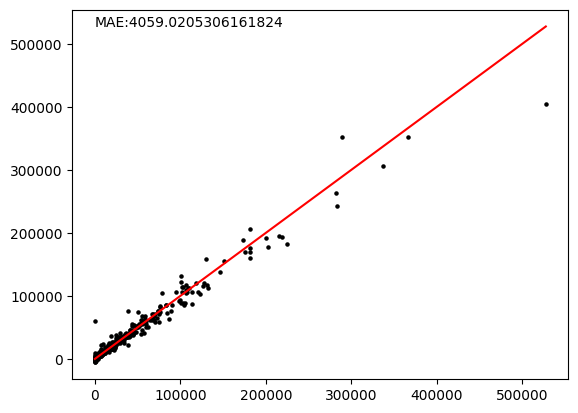

In [ ]:
import matplotlib.pyplot as plt

md = int(res.select('x_glmin', -1)[0])
ne = int(res.select('x_glmin', -1)[1])
lr = res.select('x_glmin', -1)[2]

model=xgb.XGBRegressor(max_depth=md, n_estimators=ne, learning_rate=lr)
model.fit(Tr_x[0], Tr_y[0],eval_set=evaluation,verbose=False)
pred = model.predict(Te_x[0])
MAE = mean_absolute_error(Te_y[0],pred)

maxmax = int(max(max(Te_y[0]),max(pred)))
plt.scatter(Te_y[0],pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(MAE))

These results are much better than optimization done by me with grid search. I'll repeat the optimization with more parameters: gamma, reg_alpha, reg_lambda, cosample_bytree.

In [ ]:
# Bounds for: max_depth, n_estimators, learning_rate, gamma, alpha, lambda, cosample_bytree
bounds = np.array( [ [3,15],[64,2048],[0.001,0.1],[0,10],[0,100],[0,1],[0.1,1]] )
X = np.array( [ range(3,15), range(64,2048), [i/1000 for i in range(100)],
             [i/10 for i in range(1, 100)], range(0,101),[i/100 for i in range(0, 100)],
              [i/100 for i in range(1, 100)] ])

evaluation = [(V_x[0],V_y[0])]

# for now, you need a dummy function
def XGBReg(X):
  model=xgb.XGBRegressor(max_depth=int(X[:,0][0]), n_estimators=int(X[:,1][0]),
                         learning_rate=X[:,2][0],gamma=X[:,3][0],
                         reg_alpha=int(X[:,4][0]),reg_labda=X[:,5][0],cosample_bytree=X[:,6][0])

  model.fit(Tr_x[0], Tr_y[0],eval_set=evaluation,verbose=False)
  pred = model.predict(Te_x[0])
  MAE = mean_absolute_error(Te_y[0],pred)
  return(MAE)

# BOMain object for the first objective
bo0 = BOMain(
    f=XGBReg,
    bounds=bounds,
    initpts=5,
    iterpts=50
)
res = bo0.run()

In [ ]:
# print global minimum value and location from the last iteration
Print_res(res)

Lowest MAE: 3824.2409862558925 Parameters: max_depth 7 n_estimators 1500 learning_rate 0.05428508227428427 gamma 7.249614459487385 alpha 0 lambda 0.924771382633624 cosample_bytree 0.2541302543542575


Text(0, 527618, 'MAE:4119.2331')

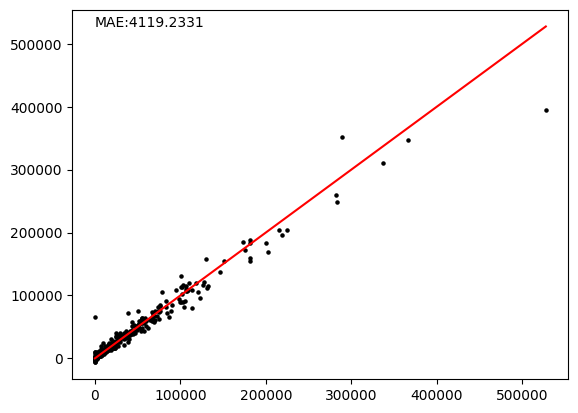

In [ ]:
md = int(res.select('x_glmin', -1)[0])
ne = int(res.select('x_glmin', -1)[1])
lr = res.select('x_glmin', -1)[2]
g = res.select('x_glmin', -1)[3]
al = int(res.select('x_glmin', -1)[4])
lm = res.select('x_glmin', -1)[5]
cs = res.select('x_glmin', -1)[6]

X = Te_x[0]#DF_5k.drop(['I','U'],axis=1)
Y = Te_y[0]#DF_5k['I']

model=xgb.XGBRegressor(max_depth=md, n_estimators=ne, learning_rate=lr,gamma=g,
                       reg_alpha=al,reg_lambda=lm,cosample_bytree=cs)
model.fit(Tr_x[0], Tr_y[0],eval_set=evaluation,verbose=False)
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)

maxmax = int(max(max(Y),max(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
_ = plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

Text(0, 842952, 'MAE:3931.2692')

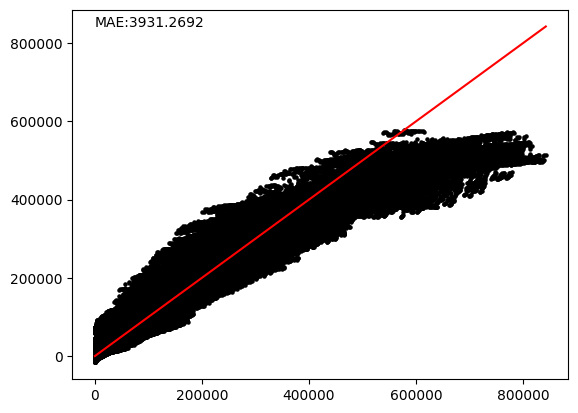

In [ ]:
pred = model.predict(DF_full.drop(['I','U'],axis=1))
MAE = mean_absolute_error(DF_full['I'],pred)

maxmax = int(max(max(DF_full['I']),max(pred)))
plt.scatter(DF_full['I'],pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

# Optimization for 15K

I decided to skip 10K, check improvement of performance in larger intervals

In [ ]:
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_15k,n_fold=5)

In [ ]:
res = BOSS_OPTIMIZE_XGBR(Tr_x,Te_x,V_x,Tr_y,Te_y,V_y)

# print global minimum value and location from the last iteration
Print_res(res)

Lowest MAE: 2054.9788112213996 Parameters: max_depth 8 n_estimators 1768 learning_rate 0.07188842557875559 gamma 5.804322137921241 alpha 26 lambda 0.2546770917802878 cosample_bytree 0.7164461193717971


Text(0, 500802, 'MAE:2405.3974')

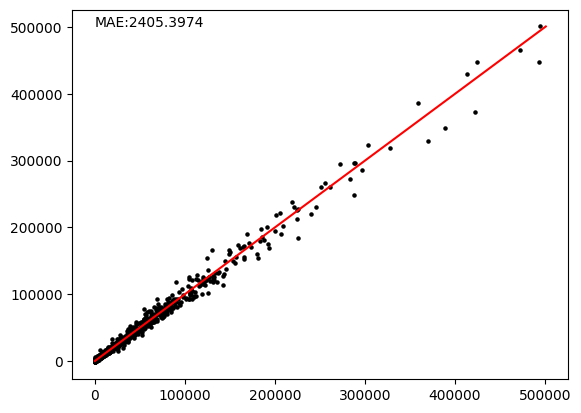

In [ ]:
md = int(res.select('x_glmin', -1)[0])
ne = int(res.select('x_glmin', -1)[1])
lr = res.select('x_glmin', -1)[2]
g = res.select('x_glmin', -1)[3]
al = int(res.select('x_glmin', -1)[4])
lm = res.select('x_glmin', -1)[5]
cs = res.select('x_glmin', -1)[6]

X = Te_x[0]#DF_5k.drop(['I','U'],axis=1)
Y = Te_y[0]#DF_5k['I']

model=xgb.XGBRegressor(max_depth=md, n_estimators=ne, learning_rate=lr,gamma=g,
                       reg_alpha=al,reg_lambda=lm,cosample_bytree=cs)
model.fit(Tr_x[0], Tr_y[0],eval_set=evaluation,verbose=False)
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)

maxmax = int(max(max(Y),max(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

Text(0, 842952, 'MAE:2393.1859')

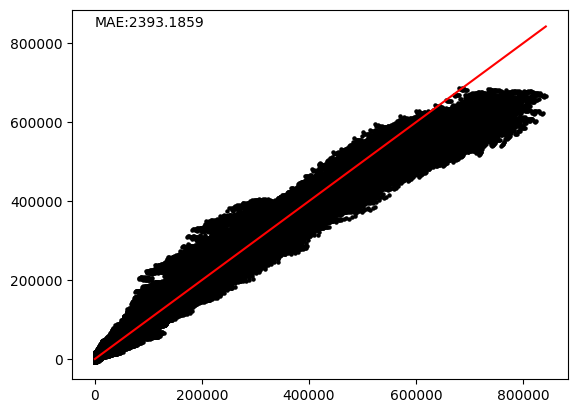

In [ ]:
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_15k,n_fold=5)
evaluation = [(V_x[0],V_y[0])]

model=xgb.XGBRegressor(max_depth=8, n_estimators=1768, learning_rate=0.07188842557875559,gamma=5.804322137921241,
                       reg_alpha=26,reg_lambda=0.2546770917802878,cosample_bytree=0.7164461193717971,n_jobs=12,device='cuda')
model.fit(Tr_x[0], Tr_y[0],eval_set=evaluation,verbose=False)

X,Y = DF_full.drop(['I','U'],axis=1), DF_full['I']
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)

maxmax = int(max(max(Y),max(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

# Optimization for 30K

In [ ]:
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_30k,n_fold=5)
evaluation = [(V_x[0],V_y[0])]

In [ ]:
res = BOSS_OPTIMIZE_XGBR(Tr_x,Te_x,V_x,Tr_y,Te_y,V_y)

bounds = np.array( [ [3,15],[64,2048],[0.001,0.1],[0,10],[0,100],[0,1],[0.1,1]] )
for i,r in enumerate(res.select('x_glmin',-1)):
  if round(r,1) in bounds[i]:
    print('Warning!!! Parameter same as bound. Increase search space!')

# print global minimum value and location from the last iteration
Print_res(res)

Lowest MAE: 1330.74678471807 
  Parameters: 
max_depth 9 
n_estimators 1718 
learning_rate 0.036521466688930936 
gamma 7.66306280712568 
alpha 54 
lambda 0.9046098288096791 
cosample_bytree 0.4400424018659419


Text(0, 673036, 'MAE:1716.58')

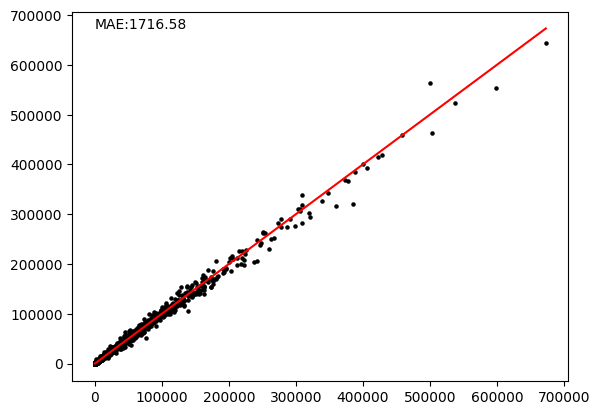

In [ ]:
md = int(res.select('x_glmin', -1)[0])
ne = int(res.select('x_glmin', -1)[1])
lr = res.select('x_glmin', -1)[2]
g = res.select('x_glmin', -1)[3]
al = int(res.select('x_glmin', -1)[4])
lm = res.select('x_glmin', -1)[5]
cs = res.select('x_glmin', -1)[6]

X = Te_x[0]#DF_5k.drop(['I','U'],axis=1)
Y = Te_y[0]#DF_5k['I']

model=xgb.XGBRegressor(max_depth=md, n_estimators=ne, learning_rate=lr,gamma=g,
                       reg_alpha=al,reg_lambda=lm,cosample_bytree=cs,n_jobs=5)
model.fit(Tr_x[0], Tr_y[0],eval_set=evaluation,verbose=False)
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)

maxmax = int(max(max(Y),max(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

Text(0, 842952, 'MAE:1718.7045')

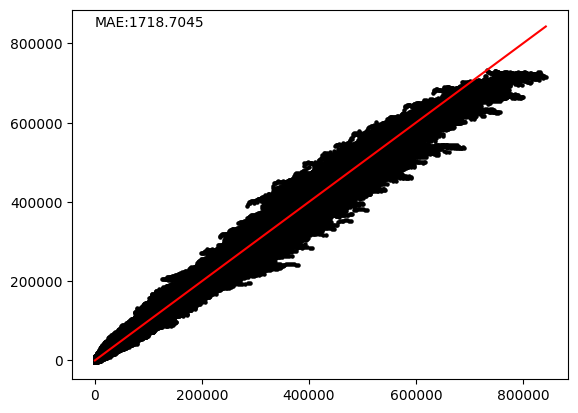

In [ ]:
X,Y = DF_full.drop(['I','U'],axis=1), DF_full['I']
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)

maxmax = int(max(max(Y),max(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

# Optimization for 60K

Warning!!! Parameter same as bound. Increase search space!
Lowest MAE: 873.5531400670632 
  Parameters: 
max_depth 9 
n_estimators 1756 
learning_rate 0.07666542988887354 
gamma 8.291654462634023 
alpha 3 
lambda 0.40469958752954427 
cosample_bytree 0.598914670868269


Text(0, 824819, 'MAE:1247.9956')

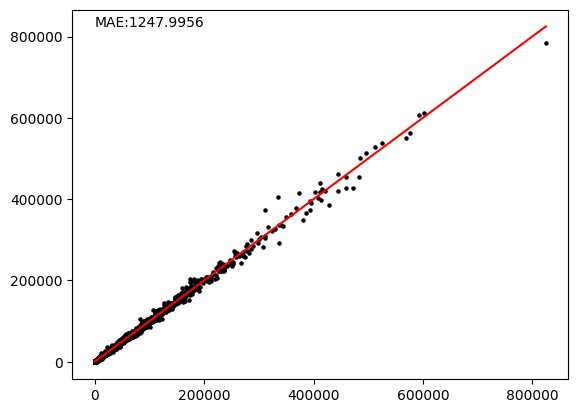

In [ ]:
DF_60k = DF_full.sample(60000)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_60k,n_fold=5)
evaluation = [(V_x[0],V_y[0])]

res = BOSS_OPTIMIZE_XGBR(Tr_x,Te_x,V_x,Tr_y,Te_y,V_y,jobs=8)

bounds = np.array( [ [3,15],[64,2048],[0.001,0.1],[0,10],[0,100],[0,1],[0.1,1]] )

Print_res(res)

md = int(res.select('x_glmin', -1)[0])
ne = int(res.select('x_glmin', -1)[1])
lr = res.select('x_glmin', -1)[2]
g = res.select('x_glmin', -1)[3]
al = int(res.select('x_glmin', -1)[4])
lm = res.select('x_glmin', -1)[5]
cs = res.select('x_glmin', -1)[6]

X = Te_x[0]
Y = Te_y[0]

model=xgb.XGBRegressor(max_depth=md, n_estimators=ne, learning_rate=lr,gamma=g,
                       reg_alpha=al,reg_lambda=lm,cosample_bytree=cs,n_jobs=8)
model.fit(Tr_x[0], Tr_y[0],eval_set=evaluation,verbose=False)
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)

maxmax = int(max(max(Y),max(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

Text(0, 842952, 'MAE:1261.9176')

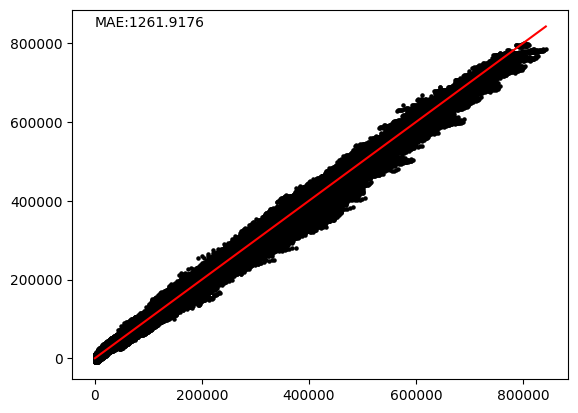

In [ ]:
X,Y = DF_full.drop(['I','U'],axis=1), DF_full['I']
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)

maxmax = int(max(max(Y),max(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

# Optimization for 100K

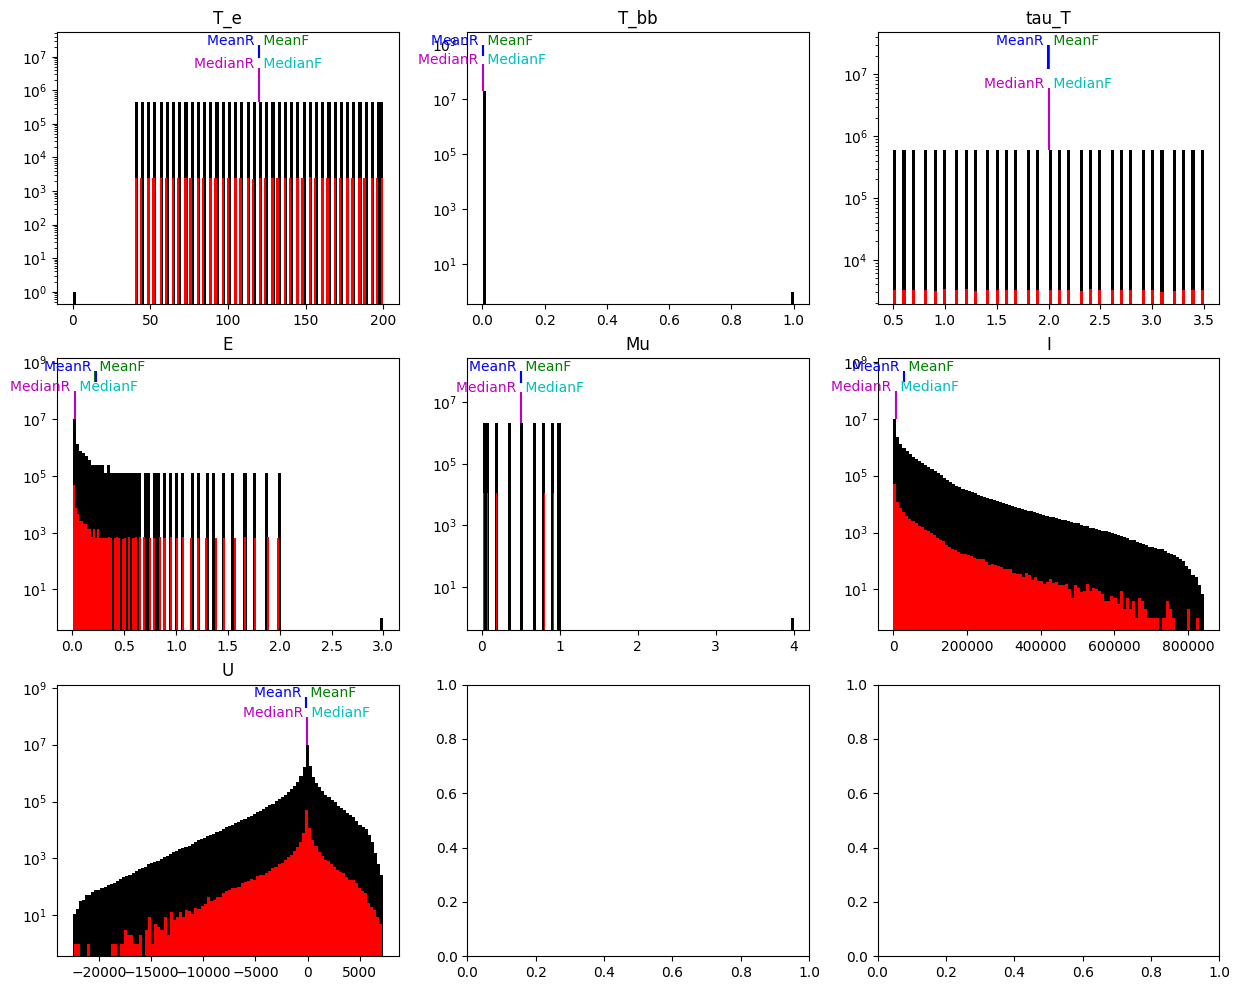

In [ ]:
make_histograms(DF_full,DF_100k)

Warning!!! Parameter cosample same as bound. Increase search space!
Parameter: 1.0 Bounds: [0.1 1. ]
Lowest MAE: 751.1405332413979 
  Parameters: 
max_depth 8 
n_estimators 1528 
learning_rate 0.04098924285092848 
gamma 14.53031085205555 
alpha 56 
lambda 1.7168584052862377 
cosample_bytree 1.0


Text(0, 797383, 'MAE:985.543')

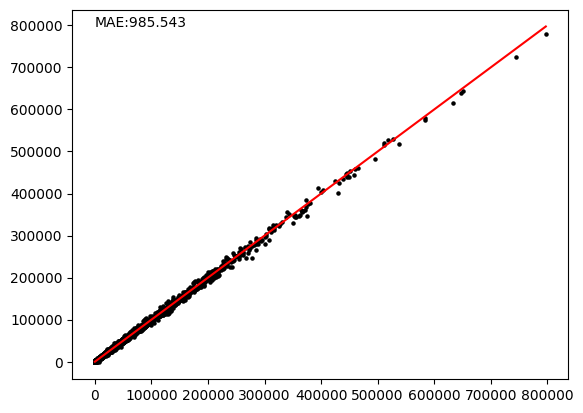

In [ ]:
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_100k,n_fold=5)
evaluation = [(V_x[0],V_y[0])]


bounds = np.array( [ [3,15],[64,2048],[0.001,0.1],[0,20],[0,100],[0,2],[0.1,1]] )

X = np.array( [ range(3,15), range(64,2048), [i/1000 for i in range(100)],
            [i/10 for i in range(1, 200)], range(0,101),[i/100 for i in range(0, 200)],
              [i/100 for i in range(1, 100)] ])


res = BOSS_OPTIMIZE_XGBR(Tr_x,Te_x,V_x,Tr_y,Te_y,V_y,jobs=12,use_device='cuda',bounds=bounds,X=X)

Print_res(res)

md = int(res.select('x_glmin', -1)[0])
ne = int(res.select('x_glmin', -1)[1])
lr = res.select('x_glmin', -1)[2]
g = res.select('x_glmin', -1)[3]
al = int(res.select('x_glmin', -1)[4])
lm = res.select('x_glmin', -1)[5]
cs = res.select('x_glmin', -1)[6]

X = Te_x[0]
Y = Te_y[0]

model=xgb.XGBRegressor(max_depth=md, n_estimators=ne, learning_rate=lr,gamma=g,
                       reg_alpha=al,reg_lambda=lm,cosample_bytree=cs,n_jobs=8)
model.fit(Tr_x[0], Tr_y[0],eval_set=evaluation,verbose=False)
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)

maxmax = int(max(max(Y),max(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

In [ ]:
# Time it took to process on TPU: 35m
# Time it took to process on T4 GPU: 21m

Text(0, 842952, 'MAE:1011.2118')

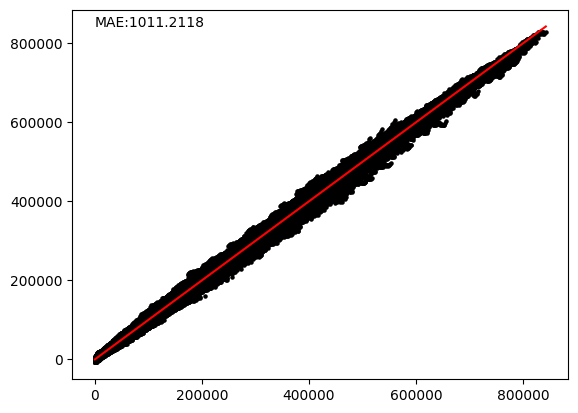

In [ ]:
X,Y = DF_full.drop(['I','U'],axis=1), DF_full['I']
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)

maxmax = int(max(max(Y),max(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

In [ ]:
model.save_model('/content/drive/MyDrive/Turku/MLMScourse/100k_model_md8_nest1528_lr0-041_g14_al56_l1-71_cs1.ubj')

# Optimization for 200k

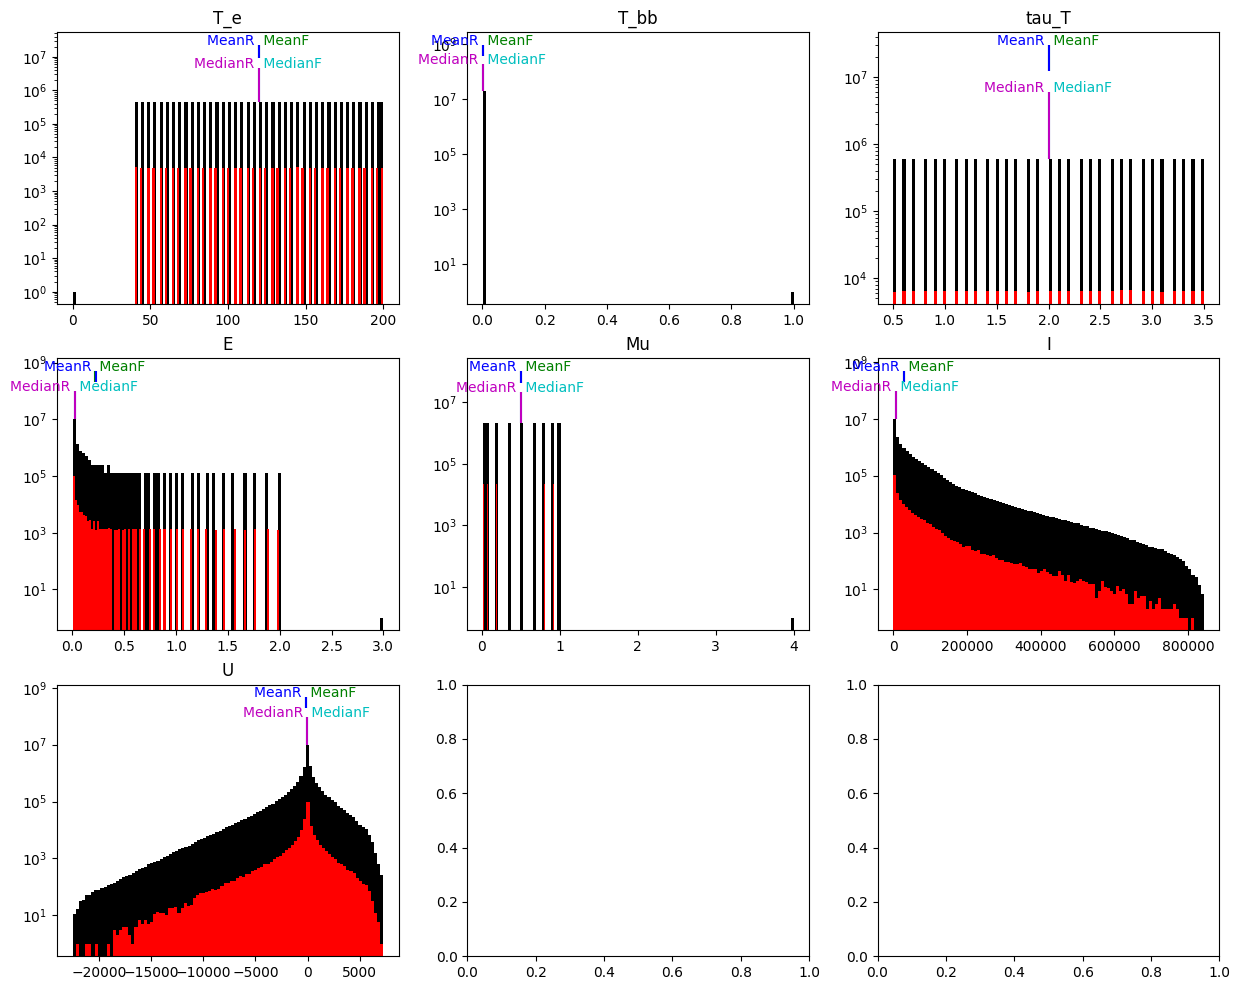

In [ ]:
DF_200k = DF_full.sample(200000)
make_histograms(DF_full,DF_200k)

Lowest MAE: 412.0828068643016 
  Parameters: 
max_depth 10 
n_estimators 1366 
learning_rate 0.03936257344087407 
gamma 3.452477891843112 
alpha 47 
lambda 0.547648929832244 
cosample_bytree 0.7365995381865204


Text(0, 815219, 'MAE:680.3331')

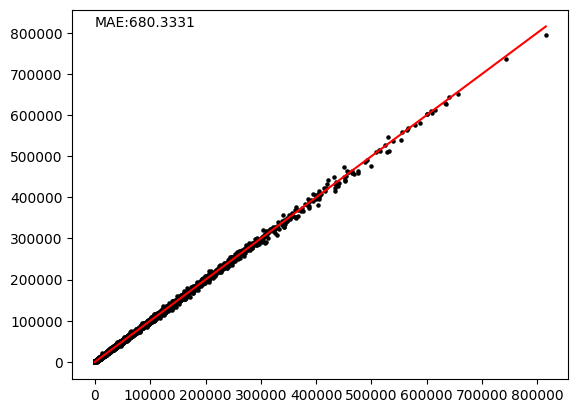

In [ ]:
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_200k,n_fold=5)
evaluation = [(V_x[0],V_y[0])]


bounds = np.array( [ [3,15],[64,2048],[0.001,0.1],[0,20],[0,100],[0,2],[0.1,1]] )

X = np.array( [ range(3,15), range(64,2048), [i/1000 for i in range(100)],
            [i/10 for i in range(1, 200)], range(0,101),[i/100 for i in range(0, 200)],
              [i/100 for i in range(1, 100)] ])


res = BOSS_OPTIMIZE_XGBR(Tr_x,Te_x,V_x,Tr_y,Te_y,V_y,jobs=32,use_device='cuda',bounds=bounds,X=X,Iters=100)

Print_res(res)

md = int(res.select('x_glmin', -1)[0])
ne = int(res.select('x_glmin', -1)[1])
lr = res.select('x_glmin', -1)[2]
g = res.select('x_glmin', -1)[3]
al = int(res.select('x_glmin', -1)[4])
lm = res.select('x_glmin', -1)[5]
cs = res.select('x_glmin', -1)[6]

X = Te_x[0]
Y = Te_y[0]

model=xgb.XGBRegressor(max_depth=md, n_estimators=ne, learning_rate=lr,gamma=g,
                       reg_alpha=al,reg_lambda=lm,cosample_bytree=cs,n_jobs=8)
model.fit(Tr_x[0], Tr_y[0],eval_set=evaluation,verbose=False)
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)

maxmax = int(max(max(Y),max(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

It took 59 minutes to train this model.

Text(0, 842952, 'MAE:696.0917')

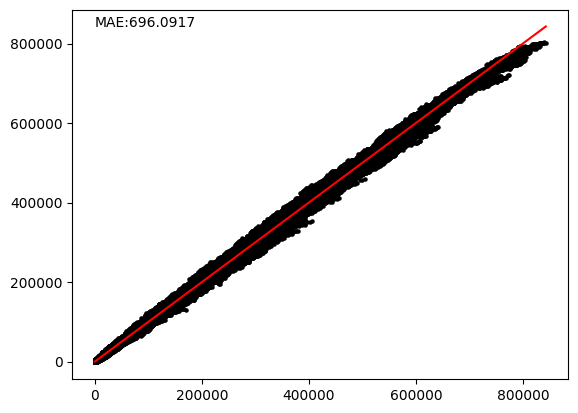

In [ ]:
X,Y = DF_full.drop(['I','U'],axis=1), DF_full['I']
pred = model.predict(X)
MAE = mean_absolute_error(Y,pred)

maxmax = int(max(max(Y),max(pred)))
plt.scatter(Y,pred,s=5,color='k')
plt.plot([i for i in range(maxmax)],[i for i in range(maxmax)],color='r')
plt.text(0,maxmax,'MAE:'+str(round(MAE,4)))

# Short summary of exploration in range 5k - 100k
Models above were trained on increasing datatasets. This allows me to create learning curve representing how models imrove when more data is accessible. For all of the models the same parameters were selected for optimization. All of them were optimized with the same approach: Bayesian optimization BOSS code.

Text(0, 0.5, 'MAE')

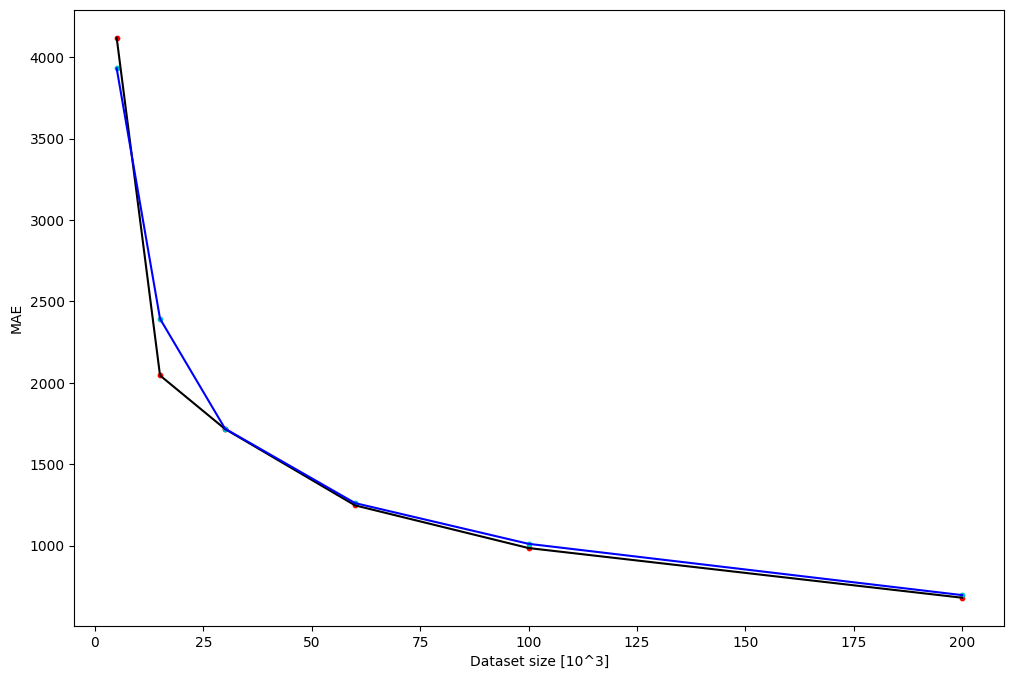

In [ ]:
MAEs = [4119,2045,1716,1247,985,680]
MAEs_full = [3931,2393,1718,1261,1011,696]
Sizes = [5,15,30,60,100,200]

f,ax = plt.subplots(figsize=[12,8])

# Predictions of dataset only
ax.plot(Sizes,MAEs,color='k')
ax.scatter(Sizes,MAEs,color='r',s=10)

# Predictions of Full data
ax.plot(Sizes,MAEs_full,color='b')
ax.scatter(Sizes,MAEs_full,color='c',s=10)

ax.set_xlabel('Dataset size [10^3]')
ax.set_ylabel('MAE')

In [ ]:
model.save_model('/content/drive/MyDrive/Turku/MLMScourse/200k_model_md10_nest1366_lr0-039_g3-45_al47_l0-54_cs073.ubj')